# Bounding box detection - Racoon data (Object Localization)


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

Please note that each image in the dataset has one racoon.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Import the necessary libraries

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

### Import the necessary libraries

In [6]:
!unrar "/content/drive/My Drive/Lab/images_racoon.zip"



UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal

Usage:     unrar <command> -<switch 1> -<switch N> <archive> <files...>
               <@listfiles...> <path_to_extract\>

<Commands>
  e             Extract files without archived paths
  l[t[a],b]     List archive contents [technical[all], bare]
  p             Print file to stdout
  t             Test archive files
  v[t[a],b]     Verbosely list archive contents [technical[all],bare]
  x             Extract files with full path

<Switches>
  -             Stop switches scanning
  @[+]          Disable [enable] file lists
  ad            Append archive name to destination path
  ag[format]    Generate archive name using the current date
  ai            Ignore file attributes
  ap<path>      Set path inside archive
  c-            Disable comments show
  cfg-          Disable read configuration
  cl            Convert names to lower case
  cu            Convert names to upper case
  dh            Open shared files
  e

### Change directory

In [0]:
import pandas as pd
import tensorflow as tf

### Load the training data from train.csv file

In [0]:
labels=pd.read_csv('/content/drive/My Drive/Lab/train_labels.csv')

In [0]:
labels['filepath']='/content/drive/My Drive/Lab/images/'+labels['filename']

In [18]:
labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,filepath
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118,/content/drive/My Drive/Lab/images/raccoon-17.jpg
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431,/content/drive/My Drive/Lab/images/raccoon-11.jpg
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290,/content/drive/My Drive/Lab/images/raccoon-63.jpg
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298,/content/drive/My Drive/Lab/images/raccoon-63.jpg
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127,/content/drive/My Drive/Lab/images/raccoon-60.jpg


In [21]:
import cv2
from tqdm import tqdm
images=[]
for i in tqdm(list(labels['filepath'])):
  img=cv2.imread(i)
  img_resize=cv2.resize(img,(128,128))
  images.append(img_resize)
  


100%|██████████| 173/173 [00:01<00:00, 145.81it/s]


In [0]:
import numpy as np
X=np.array(images)

### Print the shape of the train dataset

In [19]:
labels.shape

(173, 9)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
img_size=128
img_width=128

#### Build a Batch Generator

The batch generator should do the following:

1. Take batch_size and dataframe (build from csv file above) as input
2. Build random row indexes equal to batch size from the dataframe
3. Based on random indexes created above, read the dataframe to do following:
   - Read image and resize the image to 128x128
   - Convert it to numpy array
   - Read bounding box co-ordinates from dataframe for this image
   - Resize co-ordinates as we have resized the image
   - 'yield' batch of images and batch of co-ordinates
   
Please note that there is no classification task here as all images do have racoon's in them.

In [0]:
def batch_generator(df, batch_size=32):

    while True:

        #Create indexes
        image_nums = np.random.randint(0,df.shape[0], size=batch_size)

        #Create empty arrays
        #1. To hold image input
        batch_images = np.zeros(shape=(batch_size, img_size, img_size, 3))
#         #Classification Labels 
#         batch_labels = np.zeros(shape=(batch_size, len(num_classes)))
        #Regression labels - 4 numbers per example image
        batch_bboxes = np.zeros(shape=(batch_size, 4))
        

        for i in range(batch_size):

            #Read image and resize
            img = tf.keras.preprocessing.image.load_img(df.loc[image_nums[i], 'filepath'], 
                                                        target_size=(img_size, img_size))
            
            #Conver to numpy array
            img_array = tf.keras.preprocessing.image.img_to_array(img)

            #Update batch
            batch_images[i] = img_array

#             #Read image classification label & convert to one hot vector
#             cl_label = df.loc[image_nums[i], 'Label']
#             cl_label = tf.keras.utils.to_categorical(cl_label, num_classes=len(num_classes))
#             batch_labels[i] = cl_label

            #Read and resize bounding box co-ordinates
            img_width = df.loc[image_nums[i], 'width']
            img_height = df.loc[image_nums[i], 'height']
            
            xmin = df.loc[image_nums[i], 'xmin'] * img_size/img_width
            xmax = df.loc[image_nums[i], 'xmax'] * img_size/img_width

            ymin = df.loc[image_nums[i], 'ymin'] * img_size/img_height
            ymax = df.loc[image_nums[i], 'ymax'] * img_size/img_height

            #We will ask model to predict xmin, ymin, width and height of bounding box
            batch_bboxes[i] = [xmin, ymin, xmax-xmin, ymax-ymin]

        #Normalize batch images as per Pre-trained model to be used
        batch_images = mobilenet.preprocess_input(batch_images)
        
        #Make bounding boxes (x, y, w, h) as numbers between 0 and 1 - this seems to work better
        batch_bboxes = batch_bboxes/img_size

        #Return batch - use yield function to make it a python generator
        yield batch_images, [ batch_bboxes]

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
from keras.applications import mobilenet
from keras.layers import Conv2D,Reshape
from keras.models import Model
model= mobilenet.MobileNet(input_shape=(img_size,img_size,3),include_top=False)
for layer in model.layers:
  layer.trainable=False
  
  
  
x=model.layers[-1].output
x=Conv2D(4,kernel_size=4,name='coords')(x)
x=Reshape((4,))(x)

model=Model(inputs=model.input,outputs=[x])

### Define a custom metric function IoU which calculates Intersection Over Union

In [0]:
from keras.backend import epsilon
def calculate_iou(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(calculate_iou, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [0]:

model.compile('Adam',loss='mse',metrics=[IoU])


In [0]:
batchsize = 64
train_generator = batch_generator(labels, batch_size=batchsize)

In [54]:
model.fit_generator(train_generator,
                    epochs=30,
                    steps_per_epoch=labels.shape[0]//batchsize)

Epoch 1/30
2/2 [==============================] - 6s 3s/step - loss: 30.9887 - IoU: 0.2932
Epoch 2/30
2/2 [==============================] - 6s 3s/step - loss: 24.7987 - IoU: 0.0000e+00
Epoch 3/30
2/2 [==============================] - 4s 2s/step - loss: 13.0636 - IoU: 0.0000e+00
Epoch 4/30
2/2 [==============================] - 4s 2s/step - loss: 10.2706 - IoU: 0.4103
Epoch 5/30
2/2 [==============================] - 4s 2s/step - loss: 12.9103 - IoU: 0.1376
Epoch 6/30
2/2 [==============================] - 4s 2s/step - loss: 4.8071 - IoU: 0.0948
Epoch 7/30
2/2 [==============================] - 4s 2s/step - loss: 8.1591 - IoU: 0.0000e+00
Epoch 8/30
2/2 [==============================] - 4s 2s/step - loss: 5.4281 - IoU: 9.0000e-04
Epoch 9/30
2/2 [==============================] - 4s 2s/step - loss: 3.9184 - IoU: 0.1403
Epoch 10/30
2/2 [==============================] - 4s 2s/step - loss: 5.6635 - IoU: 0.2278
Epoch 11/30
2/2 [==============================] - 4s 2s/step - loss: 3.3984 -

### Pick a test image from the given data

In [0]:
test=X[123]

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
def predict_and_draw(image_num, df):

    #Load image
#     img = cv2.imread(df.loc[image_num, 'filepath'])
    img = cv2.imread(df.loc[image_num, 'filepath'])
    img=cv2.resize(img,(128,128))
    w, h = 128,128
    input_array=np.array(img)

    #Read actual label and bounding box
#     act_class = df.loc[image_num, 'Class']
    xmin, ymin, xmax, ymax = df.loc[image_num, ['xmin', 'ymin', 'xmax', 'ymax']]
    
    #Prepare input for model
    #1. Resize image
#     img_resized = img.resize((img_size, img_size)) 
#     #2. Conver to array and make it a batch of 1
#     input_array = tf.keras.preprocessing.image.img_to_array(img_resized)
#     input_array = np.expand_dims(input_array, axis=0)
    #3. Normalize image data
#     input_array = tf.keras.applications.mobilenet.preprocess_input(input_array)

    #Prediction
    pred = model.predict(input_array.reshape(-1,128,128,3))
    
    
    #Get classification and regression predictions
    bbox_pred=pred[0]
    #Get Label with highest probability
#     pred_class = label_class_dict[np.argmax(label_pred)]

#     print('Real Label :', act_class, '\nPredicted Label: ', pred_class)
    
    #Draw bounding boxes - Actual (Red) and Predicted(Green)
    img = cv2.imread(df.loc[image_num, 'filepath'])
    #Draw actual bounding box
    img = cv2.rectangle(img, (xmin, ymin), 
                        (xmax, ymax), (0,0,255), 2)
    #Draw predicted bounding box
    img = cv2.rectangle(img, (int(bbox_pred[0]*w), int(bbox_pred[1]*h)), 
                        (int((bbox_pred[0]+bbox_pred[2])*w), int((bbox_pred[1]+bbox_pred[3])*h)), (0,255,0), 2)

    #Display the picture
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

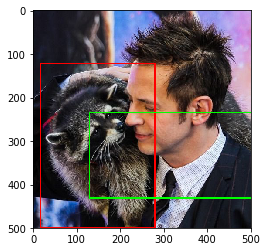

In [124]:
predict_and_draw(12,labels)

### Predict the coordinates of the bounding box for the given test image

In [0]:
region=model.predict(test.reshape(-1,128,128,3))

In [0]:
region=region[0]

In [0]:
image_width=128
IMAGE_SIZE=128
image_height=128

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

#### Change your present working directory

### Load your data file

In [127]:
data=pd.read_csv('/content/drive/My Drive/Lab/Time.csv')
data.head()

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


#### Plot data

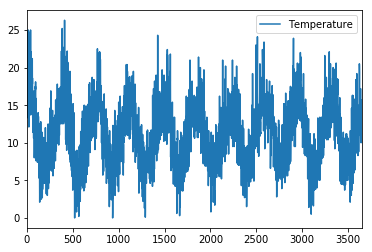

In [126]:
data.plot()

#### Descibe your dataframe

In [128]:
data.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [130]:
data.isnull().sum()

Date           0
Temperature    0
dtype: int64

#### Drop null values

In [0]:
#no null values

#### Get the representation of the distribution of data in the form of histogram

(array([ 53., 181., 564., 862., 830., 670., 347., 102.,  32.,   9.]),
 array([ 0.  ,  2.63,  5.26,  7.89, 10.52, 13.15, 15.78, 18.41, 21.04,
        23.67, 26.3 ]),
 <a list of 10 Patch objects>)

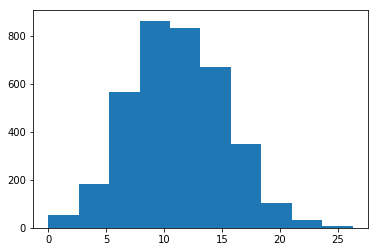

In [131]:
import matplotlib.pyplot as plt
plt.hist(data['Temperature'])

#### Check the maximum and minimum values

In [132]:
data.max()

Date           1990-12-31
Temperature          26.3
dtype: object

In [133]:
data.min()

Date           1981-01-01
Temperature             0
dtype: object

### Normalize the data

In [0]:
from sklearn.preprocessing import MinMaxScaler


#### Check the maximum and minimum values of scaled data

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data['Temperature'].values.reshape(-1,1))

#### Look into some of the scaled values

In [139]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


In [140]:
print(scaled[:10])



[[0.78707224]
 [0.68060837]
 [0.7148289 ]
 [0.55513308]
 [0.60076046]
 [0.60076046]
 [0.60076046]
 [0.66159696]
 [0.82889734]
 [0.76045627]]


### Split data into Training and Testing

In [141]:
#Create the model
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


#### Print train and test size

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [152]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.78707224]
Y 1
0.6806083650190113
1
X 1 to 2
[0.68060837]
Y 2
0.714828897338403
2
X 2 to 3
[0.7148289]
Y 3
0.5551330798479087
3
X 3 to 4
[0.55513308]
Y 4
0.6007604562737643
4
X 4 to 5
[0.60076046]
Y 5
0.6007604562737643
5
X 5 to 6
[0.60076046]
Y 6
0.6007604562737643
6
X 6 to 7
[0.60076046]
Y 7
0.6615969581749048
7
X 7 to 8
[0.66159696]
Y 8
0.8288973384030418
8
X 8 to 9
[0.82889734]
Y 9
0.7604562737642585
9
X 9 to 10
[0.76045627]
Y 10
0.6159695817490494
10
X 10 to 11
[0.61596958]
Y 11
0.5057034220532319
11
X 11 to 12
[0.50570342]
Y 12
0.6349809885931559
12
X 12 to 13
[0.63498099]
Y 13
0.8174904942965779
13
X 13 to 14
[0.81749049]
Y 14
0.9505703422053232
14
X 14 to 15
[0.95057034]
Y 15
0.7870722433460076
15
X 15 to 16
[0.78707224]
Y 16
0.7832699619771863
16
X 16 to 17
[0.78326996]
Y 17
0.9429657794676806
17
X 17 to 18
[0.94296578]
Y 18
0.6730038022813688
18
X 18 to 19
[0.6730038]
Y 19
0.5893536121673003
19
X 19 to 20
[0.58935361]
Y 20
0.6920152091254752
20
X 20 to 21


#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [0]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# print(X_train.shape)
# print(X_test.shape)

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [156]:
#The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, 
# and an output layer that makes a single value prediction. 
# The default sigmoid activation function is used for the LSTM blocks. 
# The network is trained for 100 epochs and a batch size of 1 is used.
#create and fit the LSTM network

# Hyperparameter
batch_size = 1 

model = Sequential()

model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/100
 - 8s - loss: 0.0233
Epoch 2/100
 - 6s - loss: 0.0168
Epoch 3/100
 - 6s - loss: 0.0135
Epoch 4/100
 - 6s - loss: 0.0118
Epoch 5/100
 - 6s - loss: 0.0111
Epoch 6/100
 - 6s - loss: 0.0107
Epoch 7/100
 - 6s - loss: 0.0105
Epoch 8/100
 - 6s - loss: 0.0103
Epoch 9/100
 - 6s - loss: 0.0102
Epoch 10/100
 - 6s - loss: 0.0103
Epoch 11/100
 - 6s - loss: 0.0102
Epoch 12/100
 - 6s - loss: 0.0101
Epoch 13/100
 - 6s - loss: 0.0102
Epoch 14/100
 - 6s - loss: 0.0101
Epoch 15/100
 - 6s - loss: 0.0102
Epoch 16/100
 - 6s - loss: 0.0102
Epoch 17/100
 - 6s - loss: 0.0101
Epoch 18/100
 - 6s - loss: 0.0101
Epoch 19/100
 - 6s - loss: 0.0101
Epoch 20/100
 - 6s - loss: 0.0101
Epoch 21/100
 - 6s - loss: 0.0102
Epoch 22/100
 - 6s - loss: 0.0101
Epoch 23/100
 - 6s - loss: 0.0102
Epoch 24/100
 - 6s - loss: 0.0101
Epoch 25/100
 - 6s - loss: 0.0101
Epoch 26/100
 - 6s - loss: 0.0102
Epoch 27/100
 - 6s - loss: 0.0101
Epoch 28/100
 - 6s - loss: 0.0102
Epoch 29/100
 - 6s - loss: 0.0101
Epoch 30/100
 - 6s - lo

### Summarize your model

In [158]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_3 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### Train the model

## Make Predictions and Evaluate your model

In [0]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)


In [0]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [161]:
# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.61 RMSE
Test Score: 2.47 RMSE


## Plot the results

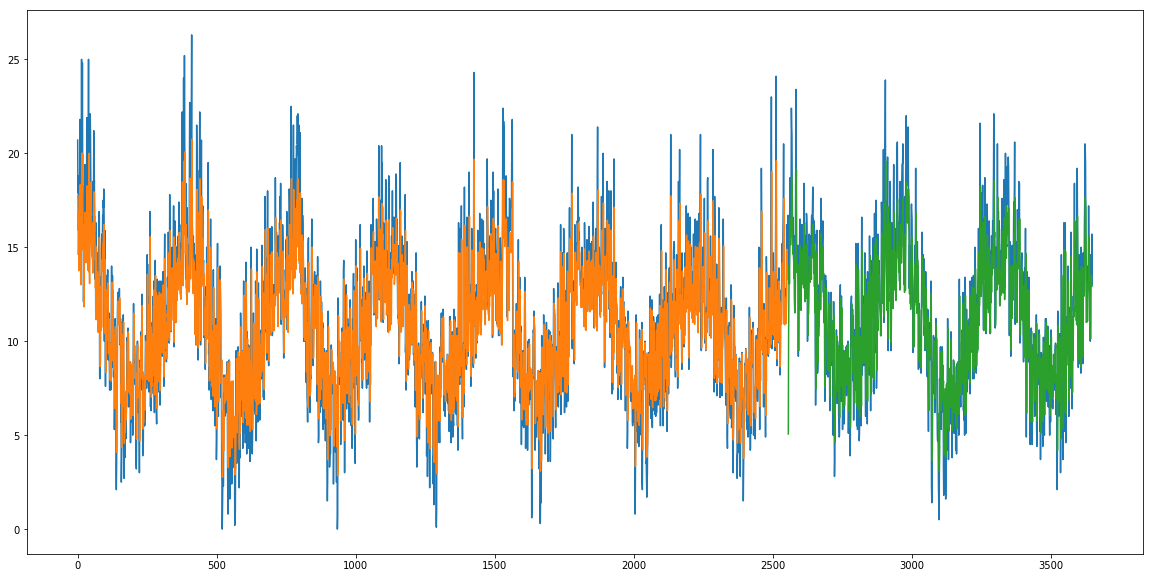

In [162]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()